# Hand-in 3, Part 2: Data Modeling

In this part you will take the csv file "reduced_field_data.csv" from Part 1, and use it to estimate the line criticality indices.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Score function

Below is a scoring function we have written for you. The output of this function is a score of how well your procedure is doing. Higher scores are worse!

As you can see, it penalizes heavily when you don't predict accurately values when they are being overloaded, i.e. false negatives.


In [7]:
def score_func(y_est, y_real):
    """
        This function takes your estimates y_est and
        scores them against the real data y_real.
        You should use this function to show how good your estimation method is.
    """
    # Square deviation
    sqr_err = np.sum(((y_est - y_real)**2).sum())
    # Penalty for not estimating a critical value above 0.95 when it occurs.
    false_negative = np.sum(np.where(np.logical_and(y_est < 0.95, y_real > 0.95), 10*np.sqrt(np.abs((y_est - y_real))), 0).sum())
    return sqr_err + false_negative

## Load and clean data

Load your data from the previous exercise as well as the criticality data.


In [39]:
# Data is loaded here
field_data = pd.read_csv("reduced_field_data.csv", index_col=0)
crit_data = pd.read_csv("flow_criticality_data.csv", index_col=0)



## Linear regression

We have implemented a simple linear regression to apply to your data.
You should use this as a benchmark for your neural network below.


In [35]:
print(field_data)

      load_node_153  export_node_130  export_node_68  export_node_108  \
0           55.0930       -13.551973      -42.135706        30.327760   
1           51.3680       -11.235127      -39.463754        28.628956   
2           48.0104       -11.064903      -36.113954        29.129438   
3           45.6761        -8.057087      -33.309821        32.912220   
4           44.6987        -6.710398      -33.277878        42.026312   
5           44.4467       -11.968168      -33.750251        37.536154   
6           44.5355       -14.185416      -33.848466        28.812487   
7           43.7847        -7.571923      -32.970572         6.303337   
8           44.0983        -6.455184      -32.062082         2.706778   
9           46.6644        -4.704244      -28.566337        13.897688   
10          50.0138        -8.997888      -24.867395        25.724247   
11          51.8567        -9.447832      -12.307933        31.812092   
12          53.1838        -9.721543       -5.91724

In [40]:
crit_data = crit_data[crit_data.index.isin(field_data['time'])].dropna(axis=0)
print(crit_data2)
#crit_data2 = crit_data2.drop(' ',1)
field_data = field_data.drop('time',1)

                     flow_89_94  flow_20_23  flow_49_64  flow_101_532  \
Time                                                                    
2012-01-01 00:00:00    0.296633    0.144482    0.341926      0.429794   
2012-01-01 01:00:00    0.286880    0.140814    0.345723      0.435347   
2012-01-01 02:00:00    0.221261    0.139097    0.329172      0.402732   
2012-01-01 03:00:00    0.139193    0.159584    0.322661      0.380344   
2012-01-01 04:00:00    0.090387    0.167504    0.288663      0.314070   
2012-01-01 05:00:00    0.079695    0.158166    0.285190      0.310177   
2012-01-01 06:00:00    0.067902    0.177036    0.304049      0.311326   
2012-01-01 07:00:00    0.029837    0.195773    0.260244      0.316251   
2012-01-01 08:00:00    0.102592    0.186906    0.169088      0.471899   
2012-01-01 09:00:00    0.274572    0.085665    0.061881      0.640687   
2012-01-01 10:00:00    0.279048    0.020958    0.144638      0.633582   
2012-01-01 11:00:00    0.285419    0.083451    0.11

Overall error: 20715.4737


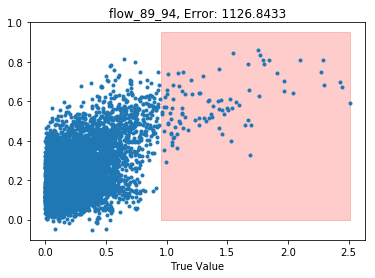

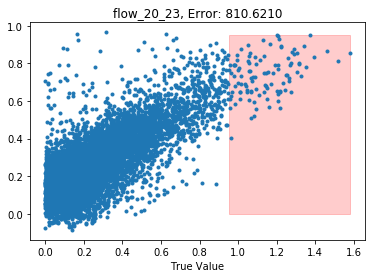

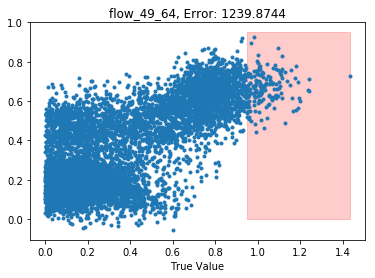

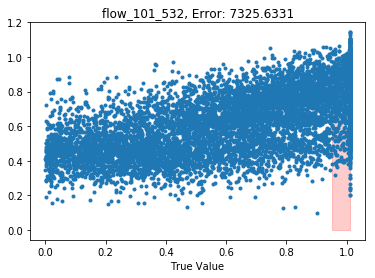

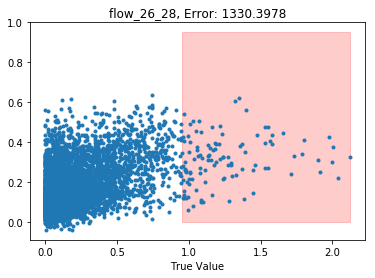

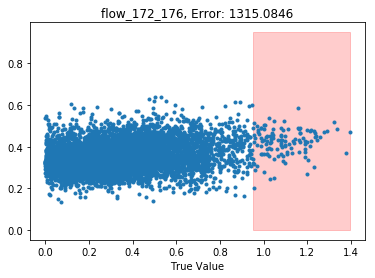

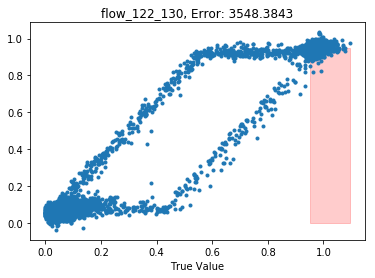

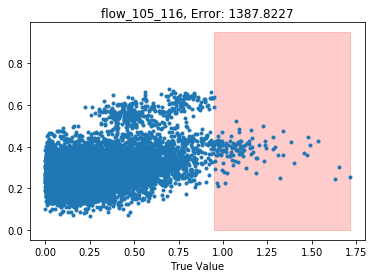

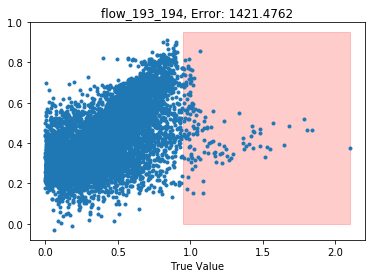

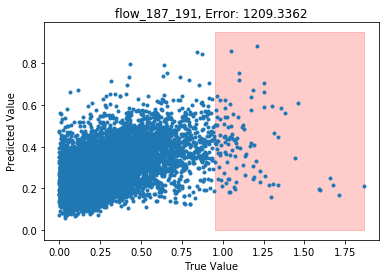

In [41]:
# The code below implements a linear regression on your data and compares predicted and true values.
# On the plots there is a red square indicating the areas corresponding to false negatives.
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(field_data,crit_data)

y_pred = lm.predict(field_data)
for index in range(10):
    plt.figure()
    plt.fill_between([0.95, crit_data.iloc[:,index].max()], [0.95, 0.95], color='r', alpha=0.2)
    plt.plot(crit_data.iloc[:,index],y_pred[:,index],'.')
    error = score_func(y_pred[:,index],crit_data.iloc[:,index])
    plt.title('{0}, Error: {1:.04f}'.format(crit_data.columns[index], error))
    plt.xlabel('True Value')

plt.ylabel('Predicted Value')
print('Overall error: {0:.04f}'.format(score_func(y_pred, crit_data)))


**Q#6** Would you recommend using Linear Regression for estimating line criticality indices? Why/why not?

# Neural Network

You should now produce a neural network that can estimate criticality indices.
Split your data into a training and test set, build your neural network below, and use the score_func defined above to estimate your model quality.

**Q#7** Explain why you chose the layers, nodes and activation functions you did. (No wrong answers, we want to know your thought process!) What is the best score you can get with a single layer?

In [43]:
# Split data into training and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(field_data, crit_data, test_size=0.20, random_state=42)

In [80]:
#INSERT Neural Network Code here for a linear regression.


from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
model = Sequential()
model.add(Dense(10, input_shape=(20,)))
model.add(Activation('relu'))

adam = optimizers.Adam(lr=0.01, beta_1=0.85,
beta_2=0.999, epsilon=1e-06, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam)
model.fit(x_train.values,y_train.values,
epochs = 80, batch_size=250, shuffle=False)
y_pred = model.predict(x_test.values, batch_size = 1000)

print("Score: ", score_func(y_pred, y_test))


Epoch 1/80
6648/6648 [==============================] - 0s - loss: 4992.7406     
Epoch 2/80
6648/6648 [==============================] - 0s - loss: 212.0129     
Epoch 3/80
6648/6648 [==============================] - 0s - loss: 60.8673     
Epoch 4/80
6648/6648 [==============================] - 0s - loss: 29.9894     
Epoch 5/80
6648/6648 [==============================] - 0s - loss: 18.5032     
Epoch 6/80
6648/6648 [==============================] - 0s - loss: 12.8178     
Epoch 7/80
6648/6648 [==============================] - 0s - loss: 9.4500      
Epoch 8/80
6648/6648 [==============================] - 0s - loss: 7.2405     
Epoch 9/80
6648/6648 [==============================] - 0s - loss: 5.7058     
Epoch 10/80
6648/6648 [==============================] - 0s - loss: 4.5817     
Epoch 11/80
6648/6648 [==============================] - 0s - loss: 3.7293     
Epoch 12/80
6648/6648 [==============================] - 0s - loss: 3.0676     
Epoch 13/80
6648/6648 [================

# K-fold cross validation

To ensure that your neural network actually works when presented with new data, take the neural network you defined above, and perform a k-fold cross validation on it.

**Q#8** Using a test window size of one tenth of your data (ten-fold cross validation), plot a histogram of the output of score_func for the validation. Tweak your neural network to achieve the lowest mean score.H

In [ ]:
# Your k-fold code goes here.

**Q#9** Are you satisfied with the quality of the final estimator? What would be your recommendation for your boss on this issue?

# Extra task for 3-person groups

**Q#10** Repeat the process, once reducing to 15 sensors, and once reducing to 25 sensors. The costs to keep these sensors running is directly proportional to the number of sensors used. Does changing the number of sensors used change your conclusion in Q#9?